In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf
import itertools
import statsmodels.api as sm

In [273]:
plt.style.use('seaborn-v0_8')
plt.style.use('fivethirtyeight')

In [522]:
def report_performance(actual,pred):
    print(f"RMSE: {np.sqrt(mean_squared_error(actual,pred)):.2f}, MAPE: {mean_absolute_percentage_error(actual,pred):.2f}")
    print(f"MAE: {mean_absolute_error(actual,pred):.2f}, MaxE: {max_error(actual,pred):.2f}")
    print(f"R2: {r2_score(actual,pred):.2f}")

## Load data into one table

In [3]:
df_center = pd.read_csv('fulfilment_center_info.csv')
df_meal = pd.read_csv('meal_info.csv')
df_train = pd.read_csv('train.csv')
df = df_train.merge(df_meal,on='meal_id',how='left').merge(df_center,on='center_id',how='left')

In [4]:
df

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,Indian,473,77,TYPE_A,4.5
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,Indian,473,77,TYPE_A,4.5
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,Italian,473,77,TYPE_A,4.5
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,Italian,473,77,TYPE_A,4.5


In [5]:
df.isna().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

In [14]:
df[['week','center_id','meal_id']].duplicated().sum()

0

## Set up data transformers and models

Encode the week with a periodic encoding, using both sin and cos to avoid same-value encoding

In [4]:
def encode_week_sin(x):
    return np.sin(x*2*np.pi/52)
def encode_week_cos(x):
    return np.cos(x*2*np.pi/52)
def encode_week(x):
    return 1.0*x/52.0

Encode the categorical/label/id variables with a one-hot encoder and the numerical variables with a standard scaling encoder.

In [284]:
preprocessor = ColumnTransformer(
    transformers = [
        ('scaler',StandardScaler(),['op_area','checkout_price','base_price']),
        ('onehot',OneHotEncoder(),['center_id','meal_id','category','cuisine','city_code','region_code','center_type']),
        ('week',FunctionTransformer(encode_week),['week'])
        #('week_sin',FunctionTransformer(encode_week_sin),['week']),
        #('week_cos',FunctionTransformer(encode_week_cos),['week'])
    ],
    remainder='passthrough'
)

In [272]:
0.2*144

28.8

Save the last 29 weeks (~20% of the dataset) for testing forecasting capability.

Set up function to evaluate a model using only data for one center and meal

In [300]:
def evaluate_model_single_center_meal(model_predict,df,x,y,center,meal):
    indices = df[(df['center_id']==center) & (df['meal_id'] == meal)].index
    indices = indices[indices >= x.index[0]]
    indices = indices[indices <= x.index[-1]]
    x_eval = x.iloc[indices,:]
    y_actual = y.iloc[indices]
    y_pred = model_predict(x_eval)
    return y_pred,y_actual

## Baseline Model - Forecasting a center's meal orders as the mean of that center's weekly orders for that meal.

In [309]:
df

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,Indian,473,77,TYPE_A,4.5
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,Indian,473,77,TYPE_A,4.5
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,Italian,473,77,TYPE_A,4.5
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,Italian,473,77,TYPE_A,4.5


In [311]:
df_train_baseline = df[df['week'] <= 116]
df_test_baseline = df[df['week'] > 116]
X_train_baseline = df_train_baseline[['center_id','meal_id']]
y_train_baseline = df_train_baseline['num_orders']
X_test_baseline = df_test_baseline[['center_id','meal_id']]
y_test_baseline = df_test_baseline['num_orders']

In [312]:
baseline_df = pd.concat([X_train_baseline[['center_id','meal_id']],y_train_baseline],axis=1).groupby(by=['center_id','meal_id'],as_index=False).mean()

In [313]:
baseline_df.query('center_id==55 and meal_id==1885')['num_orders'].values[0]

253.29310344827587

In [314]:
def baseline_predict(xtest):
    y_pred = np.zeros(len(xtest))
    for i in range(len(xtest)):
        test_row = xtest.iloc[i,]
        center_id = test_row['center_id']
        meal_id = test_row['meal_id']
        relevant_baseline_row = baseline_df.query(f'center_id=={center_id} and meal_id=={meal_id}')
        if len(relevant_baseline_row) == 1:
            y_pred[i] = relevant_baseline_row['num_orders'].values[0]
        else:
            y_pred[i] = 0
    return y_pred

In [316]:
y_pred_baseline = baseline_predict(X_test_baseline)

In [530]:
report_performance(y_test_baseline,y_pred_baseline)

RMSE: 248.96, MAPE: 0.81
MAE: 109.75, MaxE: 11916.54
R2: 0.54


## Model with entire dataset

In [320]:
num_columns = ['op_area', 'checkout_price', 'base_price']
cat_columns = ['center_id','meal_id','category','cuisine','city_code','region_code','center_type']
df_processed = df.copy()
df_processed = pd.get_dummies(df_processed, columns=cat_columns)
for col in num_columns: 
    df_processed[col] = StandardScaler().fit_transform(df_processed[col].values.reshape(-1,1))
df_processed['week'] = FunctionTransformer(encode_week).fit_transform(df_processed['week'].values.reshape(-1,1))
df_processed = df_processed.drop(drop_num_columns + drop_cat_columns,axis=1)

df_train = df_processed[df['week'] <= 116]
df_test = df_processed[df['week'] > 116]
X_train_noshift = df_train.drop(['num_orders','id'],axis=1)
y_train_noshift = df_train['num_orders']
X_test_noshift = df_test.drop(['num_orders','id'],axis=1)
y_test_noshift = df_test['num_orders']

In [529]:
lr_model_noshift = LinearRegression()
lr_model_noshift.fit(X_train_noshift,y_train_noshift)
y_pred = lr_model_noshift.predict(X_test_noshift)
report_performance(y_test_noshift,y_pred)

RMSE: 260.15, MAPE: 1.66
MAE: 149.37, MaxE: 11840.85
R2: 0.49


In [239]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

X_train_sm = X_train_sm.drop(X_train_sm.filter(like='base_').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='city_code').columns, axis=1)
X_train_sm = X_train_sm.drop(X_train_sm.filter(like='center_id').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='meal_id').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='category').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='cuisine').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='region_code').columns, axis=1)
X_train_sm = X_train_sm.drop(X_train_sm.filter(like='center_type').columns, axis=1)

X_test_sm = X_test_sm.drop(X_test_sm.filter(like='base_').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='city_code').columns, axis=1)
X_test_sm = X_test_sm.drop(X_test_sm.filter(like='center_id').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='meal_id').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='category').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='cuisine').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='region_code').columns, axis=1)
X_test_sm = X_test_sm.drop(X_test_sm.filter(like='center_type').columns, axis=1)

model = sm.OLS(y_train,X_train_sm)
res = model.fit()
print(res.summary())
y_pred = res.predict(X_test_sm)
report_performance(y_test,y_pred)

                            OLS Regression Results                            
Dep. Variable:             num_orders   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     3038.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:51:55   Log-Likelihood:            -2.5666e+06
No. Observations:              361348   AIC:                         5.133e+06
Df Residuals:                  361242   BIC:                         5.134e+06
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.058e+

In [322]:
xgb_model_noshift = xgb.XGBRegressor(n_estimators=200)
xgb_model_noshift.fit(X_train_noshift,y_train_noshift)
y_pred_noshift = xgb_model.predict(X_test_noshift)
report_performance(y_test,y_pred_noshift)

MSE: 29474.15, MAPE: 0.63
MAE: 84.33, MaxE: 9905.11
R2: 0.78


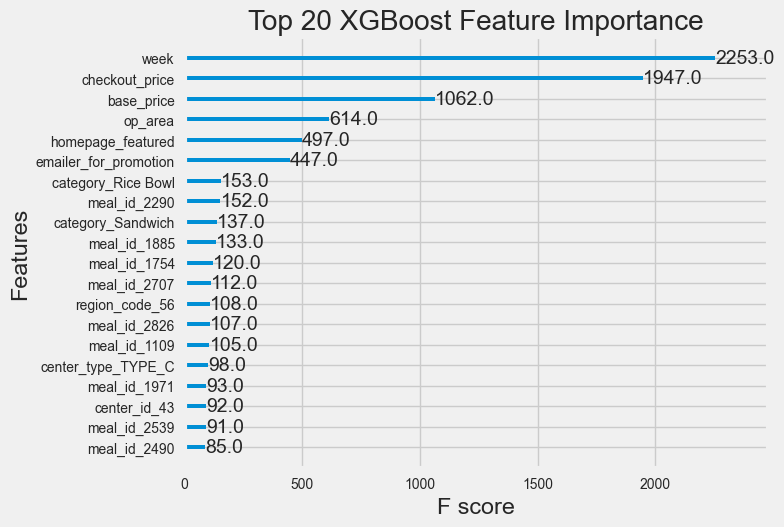

In [476]:
fig,ax = plt.subplots()
xgb.plot_importance(xgb_model_noshift, ax=ax, max_num_features=20)
ax.set_title('Top 20 XGBoost Feature Importance')
plt.tight_layout()
fig.savefig('./figs/importancenoshift.png')

### Add auto-regressive values

Add n total columns of previous values of num_orders for a given center_id and meal_id for 1,2,...,n weeks prior.

In [27]:
def append_previous_orders(df,n):
    y_pred_dict = {f'num_orders_shift{i+1}': np.zeros(len(df)) for i in range(n)}
    for i in range(len(df)):
        test_row = df.iloc[i,]
        week = test_row['week']
        center_id = test_row['center_id']
        meal_id = test_row['meal_id']
        for j in range(n):
            shifted_row = df.query(f'week=={week-(j+1)} and center_id=={center_id} and meal_id=={meal_id}')
            if len(shifted_row) == 1:
                y_pred_dict[f'num_orders_shift{j+1}'][i] = df.at[shifted_row.index[0],'num_orders']
    return pd.concat([df,pd.DataFrame(y_pred_dict)],axis=1)

In [29]:
df_AR = append_previous_orders(df,6)

In [258]:
df_AR = pd.read_csv('./df_AR.csv')

In [147]:
df_AR.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area',
       'num_orders_shift1', 'num_orders_shift2', 'num_orders_shift3',
       'num_orders_shift4', 'num_orders_shift5', 'num_orders_shift6'],
      dtype='object')

In [41]:
df_AR[df_AR['num_orders_shift1'].isin([np.inf,-np.inf])]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,city_code,region_code,center_type,op_area,num_orders_shift1,num_orders_shift2,num_orders_shift3,num_orders_shift4,num_orders_shift5,num_orders_shift6


In [30]:
df_AR

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,city_code,region_code,center_type,op_area,num_orders_shift1,num_orders_shift2,num_orders_shift3,num_orders_shift4,num_orders_shift5,num_orders_shift6
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,...,647,56,TYPE_C,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,...,647,56,TYPE_C,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,...,647,56,TYPE_C,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,...,647,56,TYPE_C,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,...,647,56,TYPE_C,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,...,473,77,TYPE_A,4.5,123.0,95.0,80.0,54.0,28.0,122.0
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,...,473,77,TYPE_A,4.5,13.0,14.0,26.0,15.0,0.0,40.0
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,...,473,77,TYPE_A,4.5,770.0,391.0,270.0,203.0,270.0,366.0
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,...,473,77,TYPE_A,4.5,811.0,447.0,432.0,284.0,161.0,419.0


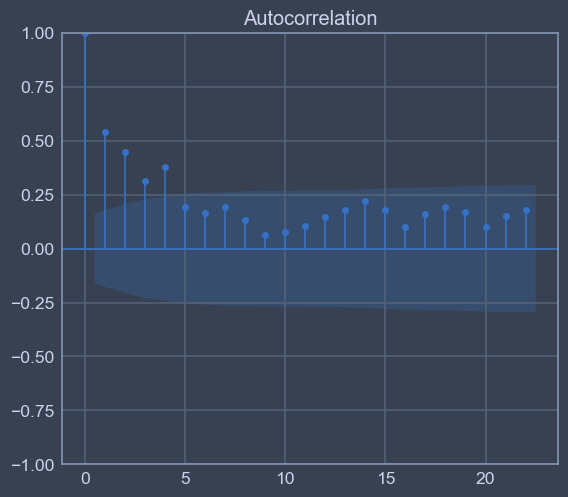

In [45]:
plot_acf(df_AR.query('center_id==55 and meal_id==1993')['num_orders_shift1']);

In [671]:
NUM_SHIFTS = 6
shift_columns = [f'num_orders_shift{i+1}' for i in range(NUM_SHIFTS)]
all_shift_columns = [f'num_orders_shift{i+1}' for i in range(6)]
drop_shift_columns = list(set(all_shift_columns)-set(shift_columns))
drop_id_columns = ['id']
# We don't need categorical columns which differentiate between meals or centers
drop_cat_columns = []
drop_num_columns = ['checkout_price']

num_columns = ['op_area', 'checkout_price', 'base_price']
cat_columns = ['center_id','meal_id','category','cuisine','city_code','region_code','center_type']
df_AR_processed = df_AR.copy()
df_AR_processed = pd.get_dummies(df_AR_processed, columns=cat_columns)
for col in num_columns: 
    df_AR_processed[col] = StandardScaler().fit_transform(df_AR_processed[col].values.reshape(-1,1))
df_AR_processed['week'] = FunctionTransformer(encode_week).fit_transform(df_AR_processed['week'].values.reshape(-1,1))
df_AR_processed = df_AR_processed.drop(drop_num_columns + drop_cat_columns + drop_shift_columns,axis=1)

df_train_AR = df_AR_processed[df_AR['week'] <= 116]
df_test_AR = df_AR_processed[df_AR['week'] > 116]
X_train_shift = df_train_AR.drop(['num_orders','id'],axis=1)
y_train_shift = df_train_AR['num_orders']
X_test_shift = df_test_AR.drop(['num_orders','id'],axis=1)
y_test_shift = df_test_AR['num_orders']

In [325]:
X_train_shift

,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,op_area,num_orders_shift1,num_orders_shift2,num_orders_shift3,num_orders_shift4,...,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C
0,0.019231,-1.277687,-1.256048,0,0,-1.908600,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,0.019231,-1.277687,-1.358465,0,0,-1.908600,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,0.019231,-1.290568,-1.358278,0,0,-1.908600,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
3,0.019231,0.047477,0.518763,0,0,-1.908600,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
4,0.019231,-0.580222,-0.694746,0,0,-1.908600,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361343,2.230769,0.922921,0.735668,0,0,0.381438,28.0,40.0,122.0,96.0,...,0,0,0,0,1,0,0,1,0,0
361344,2.230769,0.916382,0.735668,0,0,0.381438,26.0,14.0,28.0,53.0,...,0,0,0,0,1,0,0,1,0,0
361345,2.230769,-0.574076,-0.265852,0,0,0.381438,797.0,432.0,377.0,433.0,...,0,0,0,0,1,0,0,1,0,0
361346,2.230769,-0.567341,-0.278297,0,0,0.381438,959.0,418.0,621.0,487.0,...,0,0,0,0,1,0,0,1,0,0


In [670]:
lr_model_shift = LinearRegression()
lr_model_shift.fit(X_train_shift,y_train_shift)
y_pred = lr_model_shift.predict(X_test_shift)
report_performance(y_test_shift,y_pred)

RMSE: 213.45, MAPE: 1.01
MAE: 104.82, MaxE: 11697.60
R2: 0.66


In [678]:
X_train_sm = sm.add_constant(X_train_shift)
X_test_sm = sm.add_constant(X_test_shift)

#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='base_').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='city_code').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='center_id').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='meal_id').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='category').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='cuisine').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='region_code').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='center_type').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='num_orders_shift').columns, axis=1)

#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='base_').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='city_code').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='center_id').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='meal_id').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='category').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='cuisine').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='region_code').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='center_type').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_train_sm.filter(like='num_orders_shift').columns, axis=1)

model = sm.OLS(y_train_shift,X_train_sm)
res = model.fit()
print(res.summary())
y_pred = res.predict(X_test_sm)
report_performance(y_test_shift,y_pred)

                            OLS Regression Results                            
Dep. Variable:             num_orders   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     4212.
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        02:45:16   Log-Likelihood:            -2.5093e+06
No. Observations:              361348   AIC:                         5.019e+06
Df Residuals:                  361211   BIC:                         5.020e+06
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    37.02

In [679]:
X_train_sm = sm.add_constant(X_train_shift)
X_test_sm = sm.add_constant(X_test_shift)

#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='base_').columns, axis=1)
X_train_sm = X_train_sm.drop(X_train_sm.filter(like='city_code').columns, axis=1)
X_train_sm = X_train_sm.drop(X_train_sm.filter(like='center_id').columns, axis=1)
X_train_sm = X_train_sm.drop(X_train_sm.filter(like='meal_id').columns, axis=1)
X_train_sm = X_train_sm.drop(X_train_sm.filter(like='category').columns, axis=1)
X_train_sm = X_train_sm.drop(X_train_sm.filter(like='cuisine').columns, axis=1)
X_train_sm = X_train_sm.drop(X_train_sm.filter(like='region_code').columns, axis=1)
X_train_sm = X_train_sm.drop(X_train_sm.filter(like='center_type').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='num_orders_shift').columns, axis=1)

#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='base_').columns, axis=1)
X_test_sm = X_test_sm.drop(X_test_sm.filter(like='city_code').columns, axis=1)
X_test_sm = X_test_sm.drop(X_test_sm.filter(like='center_id').columns, axis=1)
X_test_sm = X_test_sm.drop(X_test_sm.filter(like='meal_id').columns, axis=1)
X_test_sm = X_test_sm.drop(X_test_sm.filter(like='category').columns, axis=1)
X_test_sm = X_test_sm.drop(X_test_sm.filter(like='cuisine').columns, axis=1)
X_test_sm = X_test_sm.drop(X_test_sm.filter(like='region_code').columns, axis=1)
X_test_sm = X_test_sm.drop(X_test_sm.filter(like='center_type').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_train_sm.filter(like='num_orders_shift').columns, axis=1)

model = sm.OLS(y_train_shift,X_train_sm)
res = model.fit()
print(res.summary())
y_pred = res.predict(X_test_sm)
report_performance(y_test_shift,y_pred)

                            OLS Regression Results                            
Dep. Variable:             num_orders   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                 4.739e+04
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        02:45:57   Log-Likelihood:            -2.5196e+06
No. Observations:              361348   AIC:                         5.039e+06
Df Residuals:                  361336   BIC:                         5.039e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    37.26

In [665]:
xgb_model_shift = xgb.XGBRegressor(n_estimators=350)
xgb_model_shift.fit(X_train_shift,y_train_shift)
y_pred = xgb_model_shift.predict(X_test_shift)
report_performance(y_test_shift,y_pred)

RMSE: 172.25, MAPE: 0.54
MAE: 78.92, MaxE: 10638.80
R2: 0.78


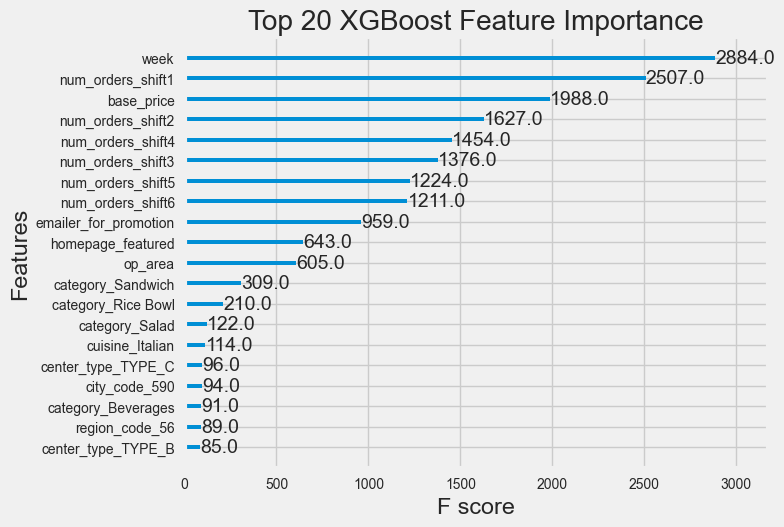

In [696]:
fig,ax = plt.subplots()
xgb.plot_importance(xgb_model_shift, ax=ax, max_num_features=20)
ax.set_title('Top 20 XGBoost Feature Importance')
plt.tight_layout()
fig.savefig('./figs/importancewithshift.pdf')

## Another ensemble model, this time one model for each center

In [656]:
NUM_SHIFTS = 6
shift_columns = [f'num_orders_shift{i+1}' for i in range(NUM_SHIFTS)]
all_shift_columns = [f'num_orders_shift{i+1}' for i in range(6)]
drop_shift_columns = list(set(all_shift_columns)-set(shift_columns))
drop_cat_columns = ['city_code', 'region_code', 'center_type']
drop_num_columns = ['op_area']
drop_id_columns_center = ['id', 'center_id', 'checkout_price']

cat_columns = ['meal_id','category','cuisine']
num_columns = ['base_price'] + shift_columns

df_AR_processed = df_AR.copy()
df_AR_processed = pd.get_dummies(df_AR_processed, columns=cat_columns)
for col in num_columns:
    df_AR_processed[col] = StandardScaler().fit_transform(df_AR_processed[col].values.reshape(-1,1))
df_AR_processed['week'] = FunctionTransformer(encode_week).fit_transform(df_AR_processed['week'].values.reshape(-1,1))
df_AR_processed = df_AR_processed.drop(drop_num_columns + drop_cat_columns + drop_shift_columns,axis=1)

df_train_AR = df_AR_processed[df_AR['week'] <= 116]
df_test_AR = df_AR_processed[df_AR['week'] > 116]
X_train_center = df_train_AR.drop('num_orders',axis=1)
y_train_center = df_train_AR['num_orders']
X_test_center = df_test_AR.drop('num_orders',axis=1)
y_test_center = df_test_AR['num_orders']

In [657]:
def ensemble_predict_center(xtest,ensemble_model):
    y_pred = pd.Series(data=0,index=xtest.index)
    for center_id in centers:
        test_rows = xtest.query(f'center_id=={center_id}').drop(drop_id_columns_center,axis=1)
        if ensemble_model[str(center_id)] and len(test_rows) > 0:
            y_pred[test_rows.index] = ensemble_model[str(center_id)].predict(test_rows)
    return y_pred

In [658]:
lr_model_ensemble_center = {}

for center_id in centers:
    lr_model = LinearRegression()
    X_train_center_temp = X_train_center.query(f'center_id=={center_id}').drop(drop_id_columns_center,axis=1)
    if len(X_train_center_temp) > 0:
        y_train_center_temp = y_train_center[X_train_center_temp.index]
        lr_model.fit(X_train_center_temp,y_train_center_temp)
        lr_model_ensemble_center[str(center_id)] = lr_model
    else:
        lr_model_ensemble_center[str(center_id)] = None

In [659]:
y_pred = ensemble_predict_center(X_test_center,lr_model_ensemble_center)
report_performance(y_test_center,y_pred)

RMSE: 2107804405524.88, MAPE: 1327889186.54
MAE: 40148281061.76, MaxE: 182712686318311.50
R2: -33309969071116828672.00


In [660]:
xgb_model_ensemble_center = {}

for center_id in centers:
    xgb_model = xgb.XGBRegressor(n_estimators=50)
    X_train_center_temp = X_train_center.query(f'center_id=={center_id}').drop(drop_id_columns_center,axis=1)
    if len(X_train_center_temp) > 0:
        y_train_center_temp = y_train_center[X_train_center_temp.index]
        xgb_model.fit(X_train_center_temp,y_train_center_temp)
        xgb_model_ensemble_center[str(center_id)] = xgb_model
    else:
        xgb_model_ensemble_center[str(center_id)] = None

In [661]:
y_pred = ensemble_predict_center(X_test_center,xgb_model_ensemble_center)
report_performance(y_test_center,y_pred)

RMSE: 180.11, MAPE: 0.57
MAE: 81.04, MaxE: 9785.04
R2: 0.76


## One last ensemble model, this time one model for each meal

In [444]:
NUM_SHIFTS = 6
shift_columns = [f'num_orders_shift{i+1}' for i in range(NUM_SHIFTS)]
all_shift_columns = [f'num_orders_shift{i+1}' for i in range(6)]
drop_shift_columns = list(set(all_shift_columns)-set(shift_columns))
drop_cat_columns = ['category','cuisine']
drop_num_columns = []
drop_id_columns_meal = ['id', 'meal_id']

cat_columns = ['center_id', 'city_code', 'region_code', 'center_type']
num_columns = ['op_area', 'checkout_price', 'base_price'] + shift_columns

df_AR_processed = df_AR.copy()
df_AR_processed = pd.get_dummies(df_AR_processed, columns=cat_columns)
for col in num_columns:
    df_AR_processed[col] = StandardScaler().fit_transform(df_AR_processed[col].values.reshape(-1,1))
df_AR_processed['week'] = FunctionTransformer(encode_week).fit_transform(df_AR_processed['week'].values.reshape(-1,1))
df_AR_processed = df_AR_processed.drop(drop_num_columns + drop_cat_columns + drop_shift_columns,axis=1)

df_train_AR = df_AR_processed[df_AR['week'] <= 116]
df_test_AR = df_AR_processed[df_AR['week'] > 116]
X_train_meal = df_train_AR.drop('num_orders',axis=1)
y_train_meal = df_train_AR['num_orders']
X_test_meal = df_test_AR.drop('num_orders',axis=1)
y_test_meal = df_test_AR['num_orders']

In [445]:
def ensemble_predict_meal(xtest,ensemble_model):
    y_pred = pd.Series(data=0,index=xtest.index)
    for meal_id in meals:
        test_rows = xtest.query(f'meal_id=={meal_id}').drop(drop_id_columns_meal,axis=1)
        if ensemble_model[str(meal_id)] and len(test_rows) > 0:
            y_pred[test_rows.index] = ensemble_model[str(meal_id)].predict(test_rows)
    return y_pred

In [578]:
lr_model_ensemble_meal = {}

for meal_id in meals:
    lr_model = LinearRegression()
    X_train_meal_temp = X_train_meal.query(f'meal_id=={meal_id}').drop(drop_id_columns_meal,axis=1)
    if len(X_train_meal_temp) > 0:
        y_train_meal_temp = y_train_meal[X_train_meal_temp.index]
        lr_model.fit(X_train_meal_temp,y_train_meal_temp)
        lr_model_ensemble_meal[str(meal_id)] = lr_model
    else:
        lr_model_ensemble_meal[str(meal_id)] = None

In [579]:
y_pred = ensemble_predict_meal(X_test_meal,lr_model_ensemble_meal)
report_performance(y_test_meal,y_pred)

RMSE: 25757254329398.04, MAPE: 11167662810.79
MAE: 1208510926601.68, MaxE: 1223301394136491.25
R2: -4974079773702722945024.00


In [456]:
xgb_model_ensemble_meal = {}

for meal_id in meals:
    xgb_model = xgb.XGBRegressor(n_estimators=50)
    X_train_meal_temp = X_train_meal.query(f'meal_id=={meal_id}').drop(drop_id_columns_meal,axis=1)
    if len(X_train_meal_temp) > 0:
        y_train_meal_temp = y_train_meal[X_train_meal_temp.index]
        xgb_model.fit(X_train_meal_temp,y_train_meal_temp)
        xgb_model_ensemble_meal[str(meal_id)] = xgb_model
    else:
        xgb_model_ensemble_meal[str(meal_id)] = None

In [684]:
y_pred = ensemble_predict_meal(X_test_meal,xgb_model_ensemble_meal)
report_performance(y_test_meal,y_pred)

RMSE: 173.17, MAPE: 0.53
MAE: 77.97, MaxE: 10558.41
R2: 0.78


## Performance Analysis

In [503]:
df_perf = df[df['week']>116].copy()
df_perf['baseline_pred'] = y_pred_baseline
df_perf['lr_noshift_pred'] = lr_model_noshift.predict(X_test_noshift)
df_perf['xgb_noshift_pred'] = xgb_model_noshift.predict(X_test_noshift)
df_perf['lr_shift_pred'] = lr_model_shift.predict(X_test_shift)
df_perf['xgb_shift_pred'] = xgb_model_shift.predict(X_test_shift)

In [504]:
df_perf['lr_center_meal_pred'] = ensemble_predict_center_meal(X_test_center_meal,lr_model_ensemble_center_meal)
df_perf['xgb_center_meal_pred'] = ensemble_predict_center_meal(X_test_center_meal,xgb_model_ensemble_center_meal)

In [505]:
df_perf['lr_center_pred'] = ensemble_predict_center(X_test_center,lr_model_ensemble_center)
df_perf['xgb_center_pred'] = ensemble_predict_center(X_test_center,xgb_model_ensemble_center)

In [506]:
df_perf['lr_meal_pred'] = ensemble_predict_meal(X_test_meal,lr_model_ensemble_meal)
df_perf['xgb_meal_pred'] = ensemble_predict_meal(X_test_meal,xgb_model_ensemble_meal)

In [507]:
df_perf

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,lr_noshift_pred,xgb_noshift_pred,lr_shift_pred,xgb_shift_pred,lr_center_meal_pred,xgb_center_meal_pred,lr_center_pred,xgb_center_pred,lr_meal_pred,xgb_meal_pred
361348,1081540,117,55,1885,148.44,147.44,0,0,162,Beverages,...,547.804688,289.048309,245.640976,125.878708,195.503545,144.197174,176.90625,88.317879,133.132812,84.020134
361349,1165036,117,55,1993,148.44,148.44,0,0,135,Beverages,...,410.054688,301.133392,239.009232,210.666794,245.314560,173.461182,202.25000,148.410324,133.992188,164.216766
361350,1355087,117,55,2539,152.35,152.35,0,0,163,Beverages,...,137.554688,182.258713,102.606216,150.653244,163.463419,105.821716,142.46875,121.327858,136.390625,157.241425
361351,1145972,117,55,2139,307.49,307.49,0,0,41,Beverages,...,-96.007812,17.084526,-22.738617,21.804945,21.188733,18.475266,20.50000,27.598640,30.635742,30.517944
361352,1011284,117,55,2631,145.50,145.50,0,0,81,Beverages,...,-75.132812,39.401211,-24.052658,60.332840,70.873305,81.779129,29.00000,100.643425,34.156250,57.462433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,...,-67.882812,58.221039,0.393265,72.977135,57.854743,60.160980,23.25000,74.022537,83.808594,91.085220
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,...,-75.132812,38.260742,-54.634918,20.841402,21.874955,40.778561,-14.40625,30.828806,33.437500,29.836510
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,...,386.867188,542.476074,509.116272,542.697510,677.237897,709.514526,455.93750,437.555450,598.828125,403.220917
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,...,330.867188,619.765991,506.738312,580.828796,705.836982,874.333313,539.15625,585.692810,612.378067,650.786133


In [492]:
pred_keys = ['baseline_pred','lr_noshift_pred','xgb_noshift_pred','lr_shift_pred','xgb_shift_pred','lr_center_meal_pred','xgb_center_meal_pred','lr_center_pred','xgb_center_pred','lr_meal_pred','xgb_meal_pred']

In [533]:
week_perf_dict = {'week': list(df_perf['week'].unique())}
for key in pred_keys:
    week_perf = []
    for week in week_perf_dict['week']:
        indices = df_perf['week']==week
        week_perf.append(np.sqrt(mean_squared_error(df_perf['num_orders'][indices],df_perf[key][indices])))
    week_perf_dict[key] = week_perf

In [537]:
week_perf_df = pd.DataFrame(week_perf_dict)

In [544]:
pred_keys_good = ['baseline_pred','lr_noshift_pred','xgb_noshift_pred','lr_shift_pred','xgb_shift_pred','xgb_center_meal_pred','xgb_center_pred','xgb_meal_pred']

In [559]:
baseline_key = ['baseline_pred']
noshift_keys = ['lr_noshift_pred','xgb_noshift_pred']
shift_keys = ['lr_shift_pred','xgb_shift_pred']
ensemble_keys = ['xgb_center_meal_pred','xgb_center_pred','xgb_meal_pred']
xgb_keys = ['xgb_noshift_pred','xgb_shift_pred','xgb_center_meal_pred','xgb_center_pred','xgb_meal_pred']

Text(0.5, 1.0, 'RMSE across all meals and centers per week on test data')

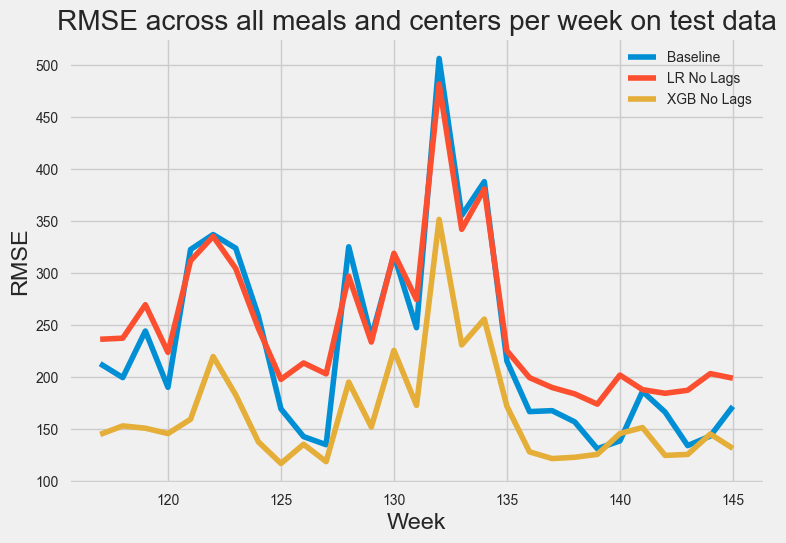

In [572]:
for key in baseline_key+noshift_keys:
    plt.plot(week_perf_df['week'],week_perf_df[key])
plt.legend(['Baseline', 'LR No Lags', 'XGB No Lags'])
plt.xlabel('Week')
plt.ylabel('RMSE')
plt.title('RMSE across all meals and centers per week on test data')

Text(0.5, 1.0, 'RMSE across all meals and centers per week on test data')

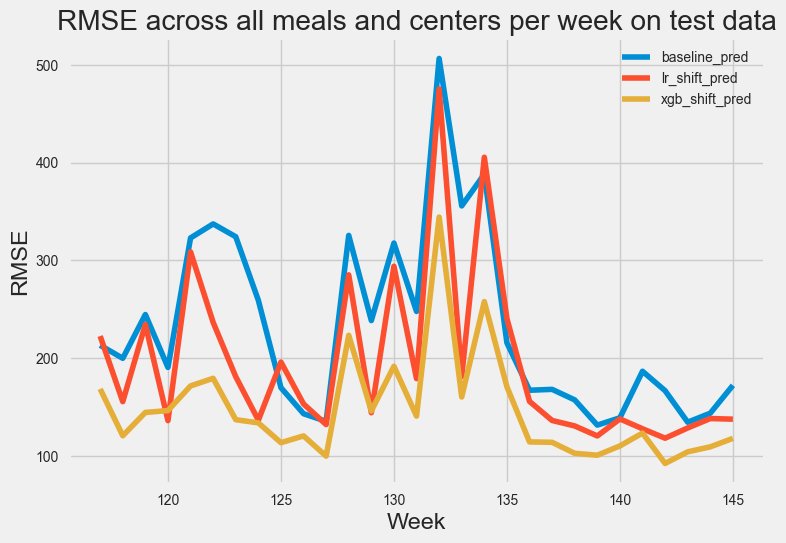

In [573]:
for key in baseline_key+shift_keys:
    plt.plot(week_perf_df['week'],week_perf_df[key])
plt.legend(baseline_key+shift_keys)
plt.xlabel('Week')
plt.ylabel('RMSE')
plt.title('RMSE across all meals and centers per week on test data')

Text(0.5, 1.0, 'RMSE across all meals and centers per week on test data')

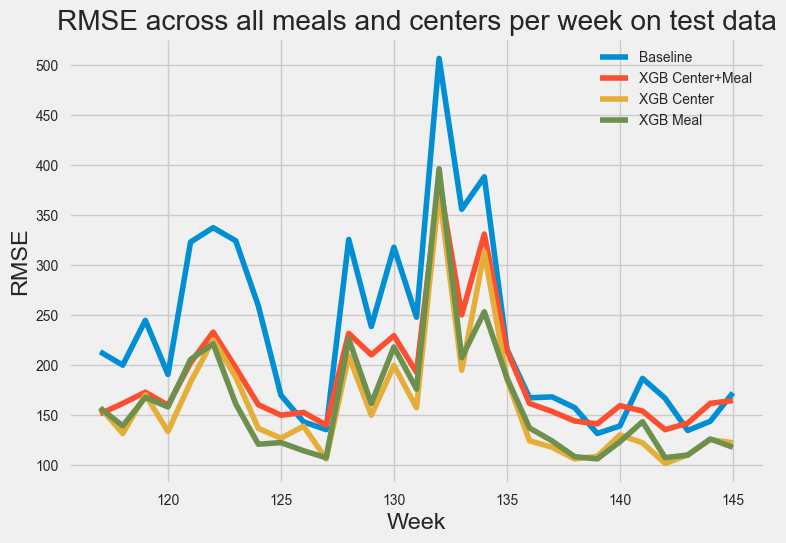

In [574]:
for key in baseline_key+ensemble_keys:
    plt.plot(week_perf_df['week'],week_perf_df[key])
plt.legend(['Baseline','XGB Center+Meal', 'XGB Center', 'XGB Meal'])
plt.xlabel('Week')
plt.ylabel('RMSE')
plt.title('RMSE across all meals and centers per week on test data')

Text(0.5, 1.0, 'RMSE across all meals and centers per week on test data')

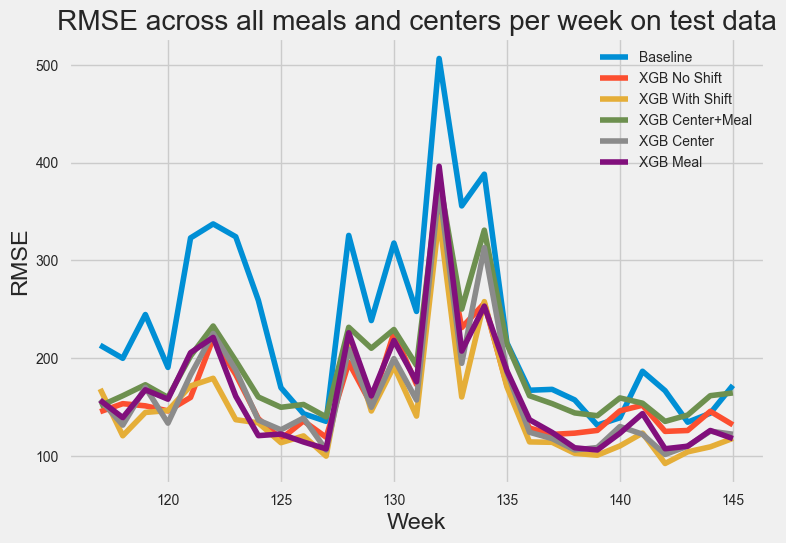

In [567]:
for key in baseline_key+xgb_keys:
    plt.plot(week_perf_df['week'],week_perf_df[key])
plt.legend(['Baseline','XGB No Shift', 'XGB With Shift', 'XGB Center+Meal', 'XGB Center', 'XGB Meal'])
plt.xlabel('Week')
plt.ylabel('RMSE')
plt.title('RMSE across all meals and centers per week on test data')

In [585]:
rmses = []
for key in pred_keys_good:
    rmses.append(np.sqrt(mean_squared_error(df_perf['num_orders'],df_perf[key])))

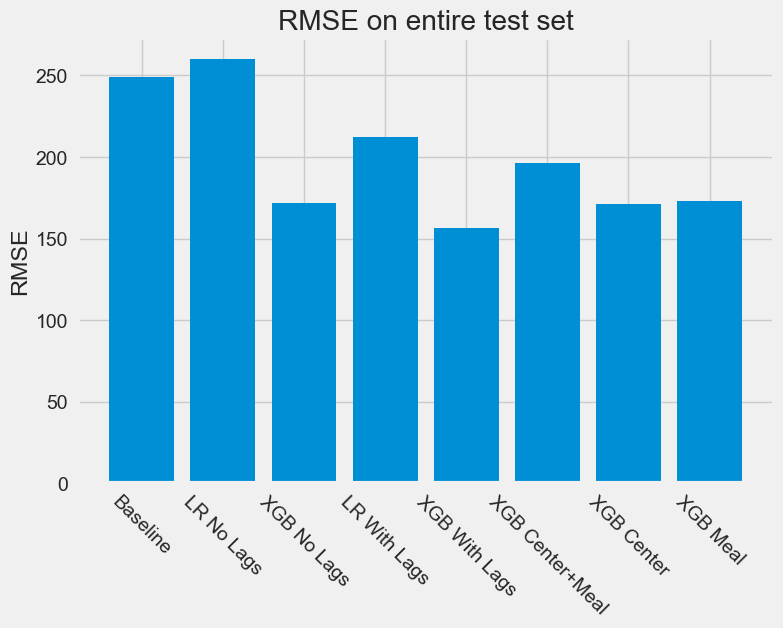

In [639]:
plt.bar(['Baseline', 'LR No Lags', 'XGB No Lags', 'LR With Lags', 'XGB With Lags', 'XGB Center+Meal', 'XGB Center', 'XGB Meal'],rmses)
plt.xticks(size=14,rotation=-45)
plt.yticks(size=14)
plt.ylabel('RMSE')
plt.title('RMSE on entire test set')
plt.savefig('./figs/rmse_pred.pdf')

In [598]:
center_perf_list = []
center_perf_columns = ['center_id','model','rmse']

for center in list(df_perf['center_id'].astype(str).unique()):
    indices = df_perf['center_id']==int(center)
    for key in pred_keys_good:
        if sum(indices) > 0:
            row = [
                center,
                key,
                np.sqrt(mean_squared_error(df_perf['num_orders'][indices],df_perf[key][indices]))
            ]
            center_perf_list.append(row)

center_perf_df = pd.DataFrame(data=center_perf_list,columns=center_perf_columns)

<AxesSubplot: xlabel='center_id', ylabel='rmse'>

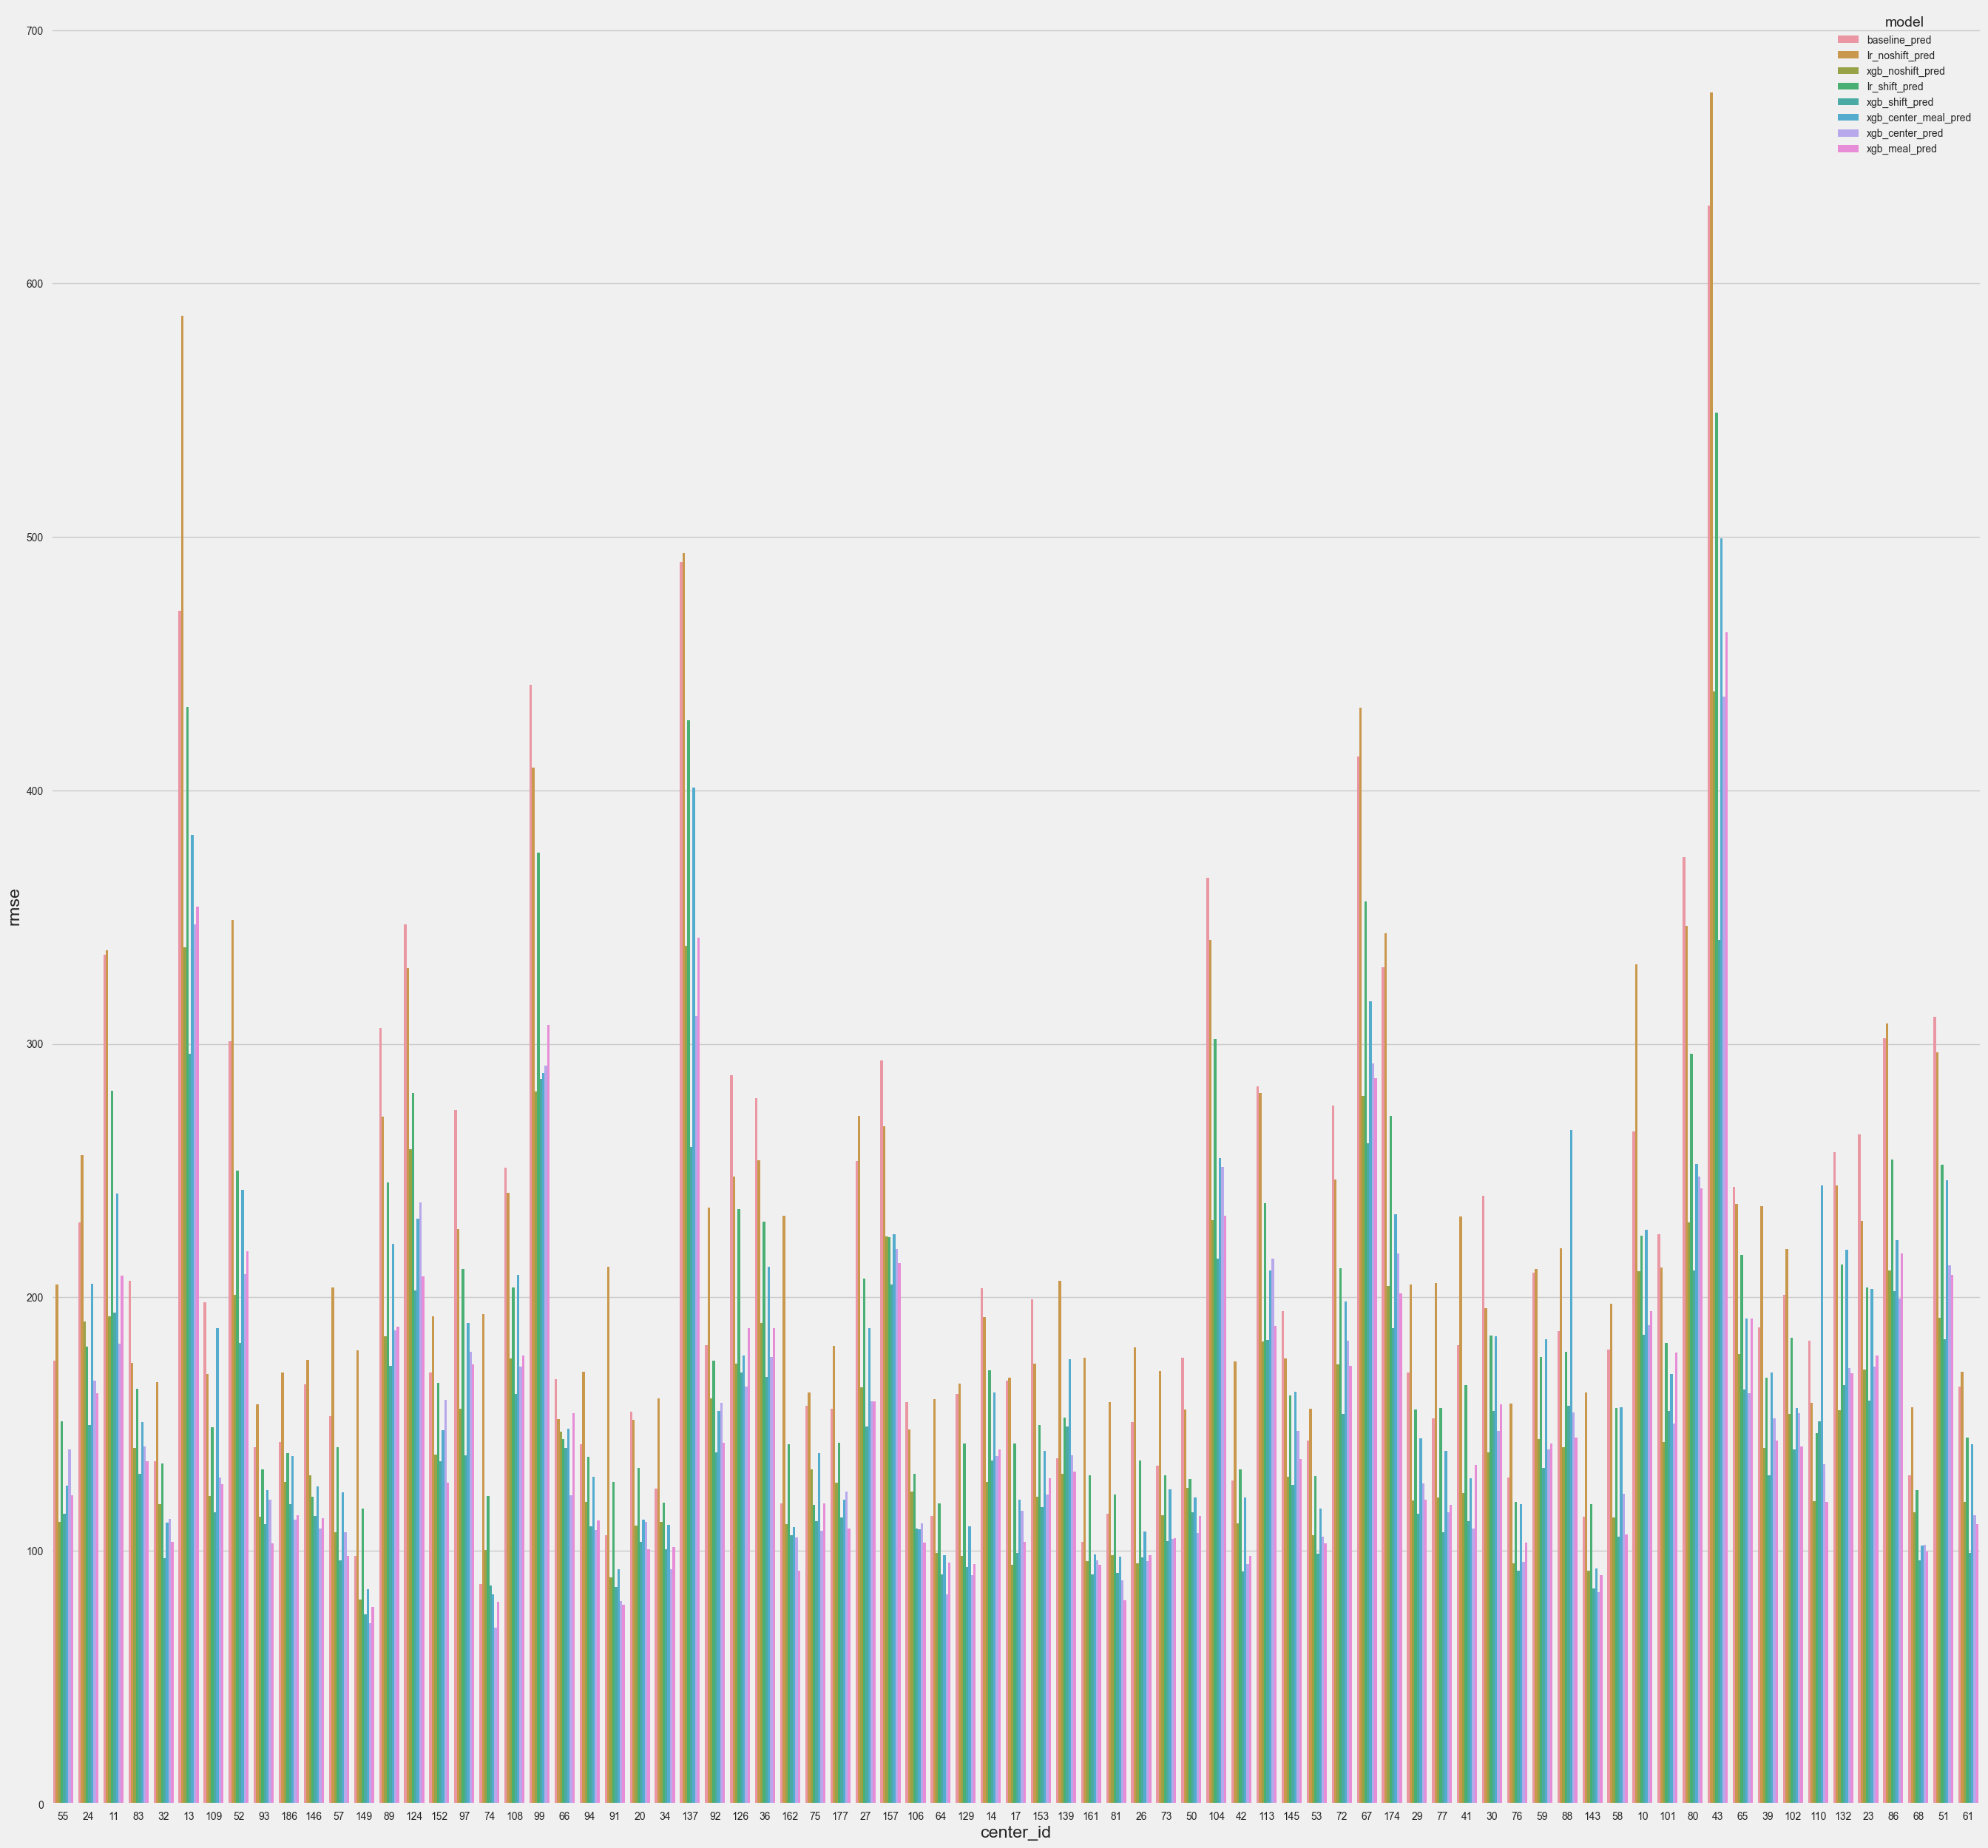

In [605]:
fig,ax = plt.subplots(figsize=(30,30))
sns.barplot(data=center_perf_df,x='center_id',y='rmse',hue='model',ax=ax)

In [612]:
category_perf_list = []
category_perf_columns = ['category','model','rmse']

for category in list(df_perf['category'].unique()):
    indices = df_perf['category']==category
    for key in pred_keys_good:
        if sum(indices) > 0:
            row = [
                category,
                key,
                np.sqrt(mean_squared_error(df_perf['num_orders'][indices],df_perf[key][indices]))
            ]
            category_perf_list.append(row)

category_perf_df = pd.DataFrame(data=category_perf_list,columns=category_perf_columns)

In [613]:
df_perf['category']

361348    Beverages
361349    Beverages
361350    Beverages
361351    Beverages
361352    Beverages
            ...    
456543       Desert
456544       Desert
456545        Salad
456546        Salad
456547        Salad
Name: category, Length: 95200, dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Beverages'),
  Text(1, 0, 'Rice Bowl'),
  Text(2, 0, 'Fish'),
  Text(3, 0, 'Starters'),
  Text(4, 0, 'Pasta'),
  Text(5, 0, 'Sandwich'),
  Text(6, 0, 'Extras'),
  Text(7, 0, 'Pizza'),
  Text(8, 0, 'Seafood'),
  Text(9, 0, 'Other Snacks'),
  Text(10, 0, 'Desert'),
  Text(11, 0, 'Salad'),
  Text(12, 0, 'Biryani'),
  Text(13, 0, 'Soup')])

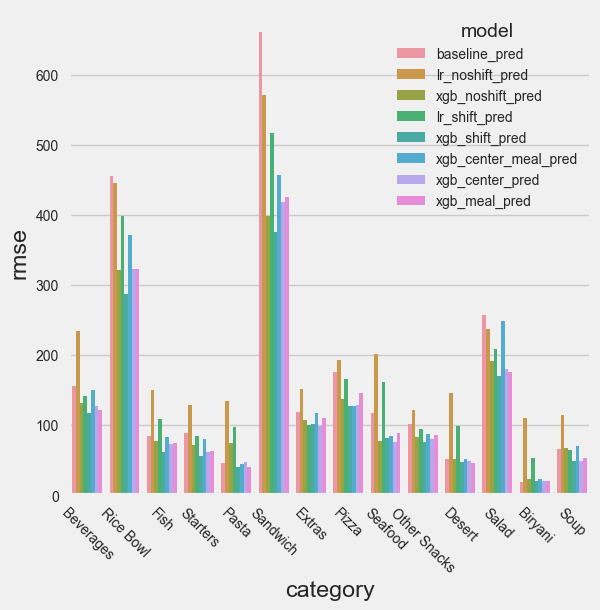

In [619]:
fig,ax = plt.subplots(figsize=(6,6))
sns.barplot(data=category_perf_df,x='category',y='rmse',hue='model',ax=ax)
plt.xticks(rotation=-45)
#plt.legend(['Baseline', 'LR No Lags', 'XGB No Lags', 'LR With Lags', 'XGB With Lags', 'XGB Center+Meal', 'XGB Center', 'XGB Meal'],title='Model')

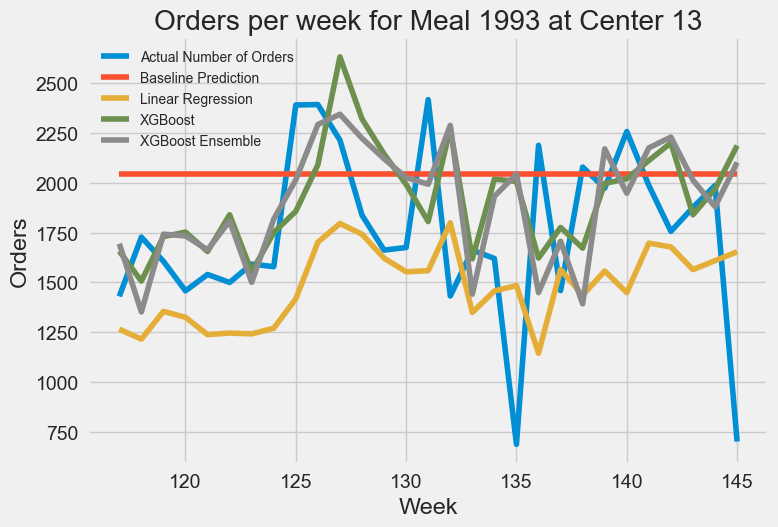

In [701]:
df_perf_sub = df_perf.query('center_id==13 and meal_id==1993')
plt.plot(df_perf_sub['week'],df_perf_sub['num_orders'])
plt.plot(df_perf_sub['week'],df_perf_sub['baseline_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['lr_shift_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_shift_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_center_pred'])
plt.legend(['Actual Number of Orders', 'Baseline Prediction', 'Linear Regression', 'XGBoost', 'XGBoost Ensemble'],loc='upper left')
plt.title('Orders per week for Meal 1993 at Center 13')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Week')
plt.ylabel('Orders')
plt.tight_layout()
plt.savefig('./figs/orders_1993_13_pred.pdf')

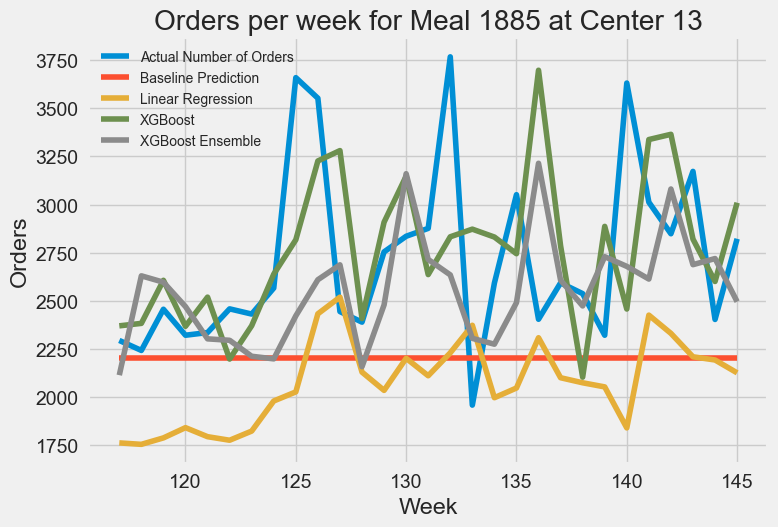

In [700]:
df_perf_sub = df_perf.query('center_id==13 and meal_id==1885')
plt.plot(df_perf_sub['week'],df_perf_sub['num_orders'])
plt.plot(df_perf_sub['week'],df_perf_sub['baseline_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['lr_shift_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_shift_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_center_pred'])
plt.legend(['Actual Number of Orders', 'Baseline Prediction', 'Linear Regression', 'XGBoost', 'XGBoost Ensemble'],loc='upper left')
plt.title('Orders per week for Meal 1885 at Center 13')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Week')
plt.ylabel('Orders')
plt.tight_layout()
plt.savefig('./figs/orders_1885_13_pred.pdf')

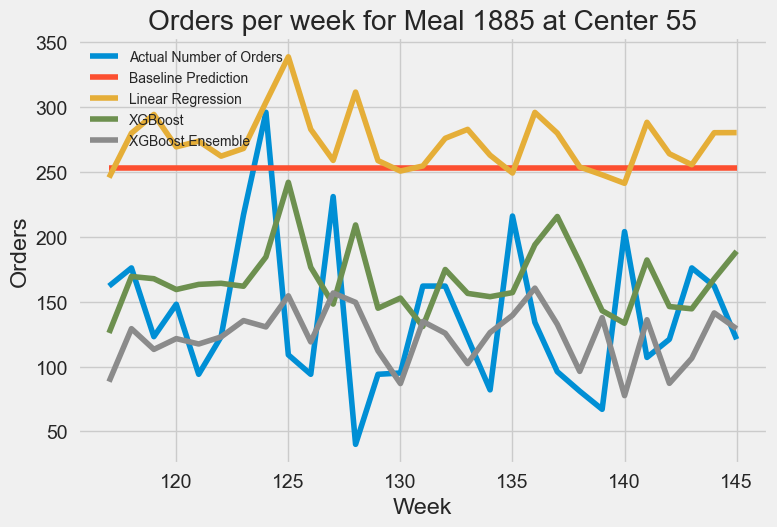

In [699]:
df_perf_sub = df_perf.query('center_id==55 and meal_id==1885')
plt.plot(df_perf_sub['week'],df_perf_sub['num_orders'])
plt.plot(df_perf_sub['week'],df_perf_sub['baseline_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['lr_shift_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_shift_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_center_pred'])
plt.legend(['Actual Number of Orders', 'Baseline Prediction', 'Linear Regression', 'XGBoost', 'XGBoost Ensemble'],loc='upper left')
plt.title('Orders per week for Meal 1885 at Center 55')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Week')
plt.ylabel('Orders')
plt.tight_layout()
plt.savefig('./figs/orders_1885_55_pred.pdf')

In [689]:
df_perf[(df_perf['xgb_shift_pred'] - df_perf['num_orders']).abs() > 5e3]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,lr_noshift_pred,xgb_noshift_pred,lr_shift_pred,xgb_shift_pred,lr_center_meal_pred,xgb_center_meal_pred,lr_center_pred,xgb_center_pred,lr_meal_pred,xgb_meal_pred
410780,1012405,132,13,1971,186.30,323.04,1,1,8979,Sandwich,...,1364.648438,2822.784912,1041.347427,2335.194824,2688.766291,2796.087402,1481.347656,2422.221191,2242.564453,1844.459473
411625,1352889,132,137,1971,171.72,316.22,1,1,11056,Sandwich,...,1218.023438,3720.329834,1711.555191,4854.658691,3362.629610,2827.444092,2076.121094,3828.949707,2457.048828,3459.076416
412745,1209098,132,67,1971,170.78,310.40,1,1,9019,Sandwich,...,1172.992188,3590.184326,1006.664368,3575.709229,2967.902554,2787.766113,1290.500000,2494.003906,2248.697266,2686.582031
413351,1346216,132,43,1971,204.70,324.04,1,1,13150,Sandwich,...,1309.148438,3244.885254,1488.629288,4996.794434,4894.510740,2586.037598,2496.535156,3313.383057,2618.916016,2591.587158


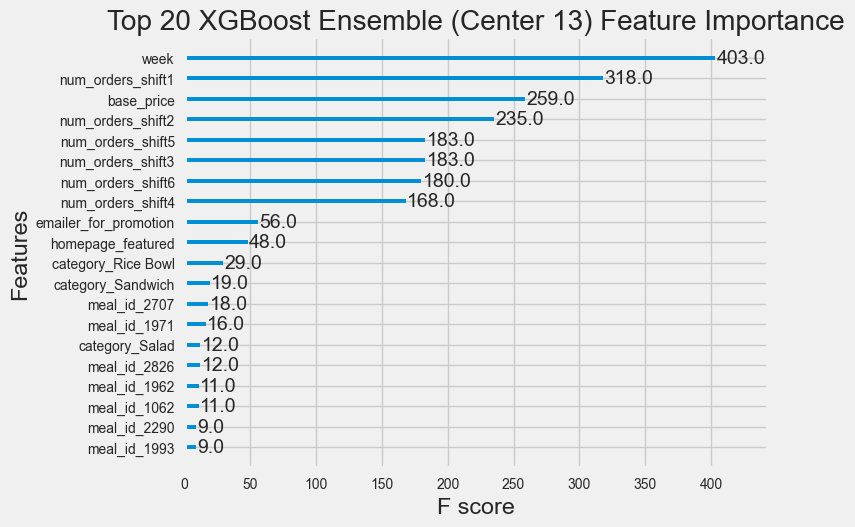

In [697]:
fig,ax = plt.subplots()
xgb.plot_importance(xgb_model_ensemble_center['13'], ax=ax, max_num_features=20)
ax.set_title('Top 20 XGBoost Ensemble (Center 13) Feature Importance')
plt.tight_layout()
fig.savefig('./figs/importanceensemble.pdf')